# NREL WIND Toolkit - Validation Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user git+http://github.com/HDFGroup/h5pyd.git
```

Then, you can make a configuration file at ~/.hscfg with contents like so:

```
# HDFCloud configuration file
hs_endpoint = https://developer.nrel.gov/api/hsds/
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

In [1]:
%matplotlib inline
from collections import OrderedDict
import h5pyd
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, ttest_rel
from pyproj import Proj

#custom plotting properties
sns.set_style("white")
sns.set_style("ticks")
meanprops = dict(marker='o', markeredgecolor='black', markerfacecolor="None",
                 markersize=5)



def indicesForCoord(f, lat_index, lon_index):
    """
    Function to find the nearest x/y indicces for a given lat/lon using Proj4 projection library
    
    Parameters
    ----------
    f : 'h5pyd.File'
        h5pyd File instance for the database
    lat_index : 'float'
        Latitude of coordinate of interest
    lon_index : 'float'
        Longitude of coordinate of interest
        
    Results
    -------
    ij : 'tuple'
        x/y coordinate in the database of the closest pixel to coordinate of interest
    """
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index, lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

[Irradiance](#Irradiance-Variables) | [Meteorological](#Meterological-Variables)

# Compare NSRDB to WIND Toolkit
## NSRDB Site
Several sites were randomly selected from the NSRDB  
Sites were chosen from different states with in the continental United States

In [2]:
nsrdb =  h5py.File('nsrdb_samples_v2.h5', 'r')
list(nsrdb)

['meta',
 'site_1181085',
 'site_681020',
 'site_715649',
 'site_915727',
 'time_index']

In [3]:
nsrdb_sites = pd.DataFrame(nsrdb['meta'][...])
nsrdb_sites

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover,gid
0,40.61,-75.54,127.48,-5,b'United States',b'Pennsylvania',b'Lehigh',b'Allentown',11756,50,1181085
1,36.65,-86.38,230.76,-6,b'United States',b'Tennessee',b'Allen',b'None',181,50,915727
2,36.73,-97.14,306.70,-6,b'United States',b'Oklahoma',b'Kay',b'None',25,20,681020
3,42.57,-95.62,420.88,-6,b'United States',b'Iowa',b'Cherokee',b'None',29,30,715649


Hourly irradiance, temperature, and wind speed was extracted for 2007-2013

In [4]:
index = 2
site_id = nsrdb_sites.loc[index, 'gid']
site_pos = nsrdb_sites['gid'] == site_id
site_lat_lon = nsrdb_sites.loc[site_pos, ['latitude', 'longitude']].values[0]
site_tz = nsrdb_sites.loc[site_pos, 'timezone'].item()
print('NSRDB site {:} coordinates = '.format(site_id), site_lat_lon)

dt = pd.to_datetime(nsrdb['time_index'][:].astype(str))
site_ds = pd.DataFrame(nsrdb['site_{:}'.format(site_id)][...],
                       index=dt)

site_ds.head()

NSRDB site 681020 coordinates =  [ 36.73 -97.14]


,dhi,dni,ghi,surface_temperature,wspd
2007-01-01 00:00:00,0,0,0,274.025269,4.775141
2007-01-01 01:00:00,0,0,0,273.460602,4.843550
2007-01-01 02:00:00,0,0,0,272.930817,4.874635
2007-01-01 03:00:00,0,0,0,272.503723,4.778934
2007-01-01 04:00:00,0,0,0,272.114014,4.697928


In [5]:
nsrdb.close()

## Nearest WIND Toolkit Site

In [6]:
wtk = h5pyd.File("/nrel/wtk-us.h5", 'r')

Find nearest WIND Toolkit site

In [7]:
wtk_ij = indicesForCoord(wtk, *site_lat_lon)

wtk_lat_lon = wtk['coordinates'][wtk_ij[0], wtk_ij[1]]
print('WTK nearest site coordinates = ', wtk_lat_lon)

WTK nearest site coordinates =  ( 36.740707, -97.137451)


Extract the same variables present in NSRDB

In [8]:
dt = pd.to_datetime(wtk['datetime'][:].astype(str))
wtk_ds = OrderedDict()
for var in ['DIF', 'DNI', 'GHI', 'temperature_2m', 'windspeed_10m']:
    wtk_ds[var] = wtk[var][:, wtk_ij[0], wtk_ij[1]]
    
wtk_ds = pd.DataFrame(wtk_ds, index=dt)
wtk_ds.head()

,DIF,DNI,GHI,temperature_2m,windspeed_10m
2007-01-01 00:00:00,0.0,0.0,0.0,274.567413,4.766991
2007-01-01 01:00:00,0.0,0.0,0.0,273.648804,4.550308
2007-01-01 02:00:00,0.0,0.0,0.0,272.989594,4.641869
2007-01-01 03:00:00,0.0,0.0,0.0,271.955017,4.394669
2007-01-01 04:00:00,0.0,0.0,0.0,271.475891,4.092529


In [9]:
wtk.close()

## Comparison

Combine NSRDB and WTK datasets to allow for comparison

In [10]:
nsrdb_comp = site_ds.copy()
nsrdb_comp = nsrdb_comp.rename(columns={'dhi': 'DHI', 'dni': 'DNI', 'ghi': 'GHI',
                                        'surface_temperature': 'Temperature', 'wspd': 'Wind Speed'})
nsrdb_comp['dataset'] = 'NSRDB'
nsrdb_comp['Temperature'] = nsrdb_comp['Temperature'] - 273.15
nsrdb_comp['zenith_angle'] = np.degrees(np.arccos((nsrdb_comp['GHI'] - nsrdb_comp['DHI']) / nsrdb_comp['DNI'])).fillna(90)

wtk_comp = wtk_ds.copy()
wtk_comp = wtk_comp.rename(columns={'DIF': 'DHI', 'temperature_2m': 'Temperature', 'windspeed_10m': 'Wind Speed'})
wtk_comp['dataset'] = 'WTK'
wtk_comp['Temperature'] = wtk_comp['Temperature'] - 273.15

comp_ds = pd.concat([nsrdb_comp, wtk_comp])
# Extract year, month and hour
comp_ds['year'] = comp_ds.index.year
comp_ds['month'] = comp_ds.index.month
# Shift hour to local time
comp_ds['hour'] = (comp_ds.index + pd.to_timedelta('{:}h'.format(site_tz))).hour

comp_ds.head()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in arccos


,DHI,DNI,GHI,Temperature,Wind Speed,dataset,zenith_angle,year,month,hour
2007-01-01 00:00:00,0.0,0.0,0.0,0.875269,4.775141,NSRDB,90.0,2007,1,18
2007-01-01 01:00:00,0.0,0.0,0.0,0.310602,4.843550,NSRDB,90.0,2007,1,19
2007-01-01 02:00:00,0.0,0.0,0.0,-0.219183,4.874635,NSRDB,90.0,2007,1,20
2007-01-01 03:00:00,0.0,0.0,0.0,-0.646277,4.778934,NSRDB,90.0,2007,1,21
2007-01-01 04:00:00,0.0,0.0,0.0,-1.035986,4.697928,NSRDB,90.0,2007,1,22


For irradiance variables non-daylight hours need to be removed

In [11]:
# Daylight hours have a zenith angle <= 89 degrees
daylight = nsrdb_comp['zenith_angle'] <= 89
cols = ['DNI', 'GHI', 'DHI', 'dataset']
solar_comp = pd.concat([nsrdb_comp.loc[daylight, cols], wtk_comp.loc[daylight, cols]])
# Extract year, month and hour
solar_comp['year'] = solar_comp.index.year
solar_comp['month'] = solar_comp.index.month

# Shift hour to local time
solar_comp['hour'] = (solar_comp.index + pd.to_timedelta('{:}h'.format(site_tz))).hour

solar_comp.head()

,DNI,GHI,DHI,dataset,year,month,hour
2007-01-01 14:00:00,202.0,25.0,16.0,NSRDB,2007,1,8
2007-01-01 15:00:00,643.0,192.0,56.0,NSRDB,2007,1,9
2007-01-01 16:00:00,816.0,356.0,72.0,NSRDB,2007,1,10
2007-01-01 17:00:00,892.0,479.0,81.0,NSRDB,2007,1,11
2007-01-01 18:00:00,924.0,545.0,85.0,NSRDB,2007,1,12


# Irradiance Variables

[GHI](#Global-Horizontal-Irradiance) | [DHI](#Diffuse-Horizontal-Irradiance) | [DNI](#Direct-Normal-Irradiance)

#### Global Horizontal Irradiance

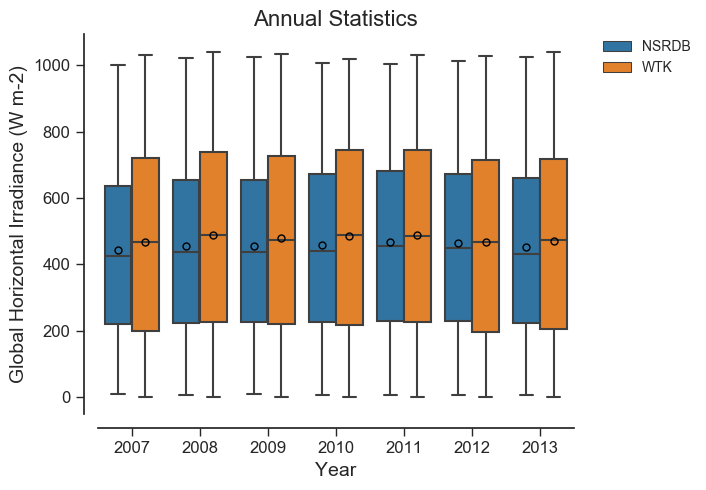

,2007,2008,2009,2010,2011,2012,2013
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0


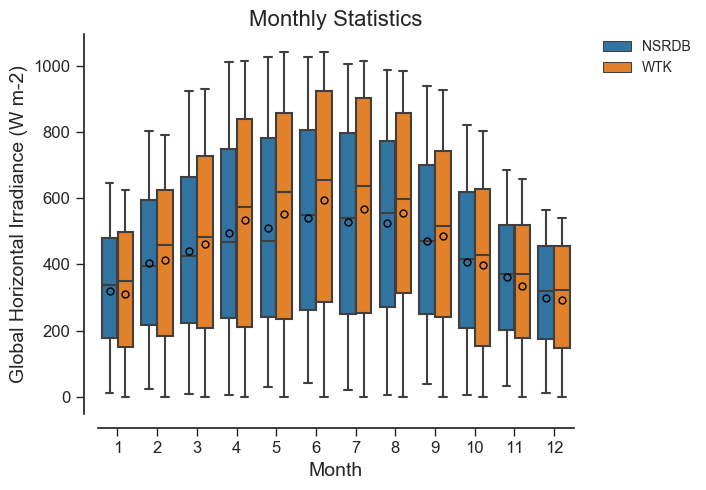

,1,2,3,4,5,6,7,8,9,10,11,12
p-value,0.0,0.0,0.57,0.0,0.0,0.0,0.0,0.0,0.18,0.0,0.0,0.0


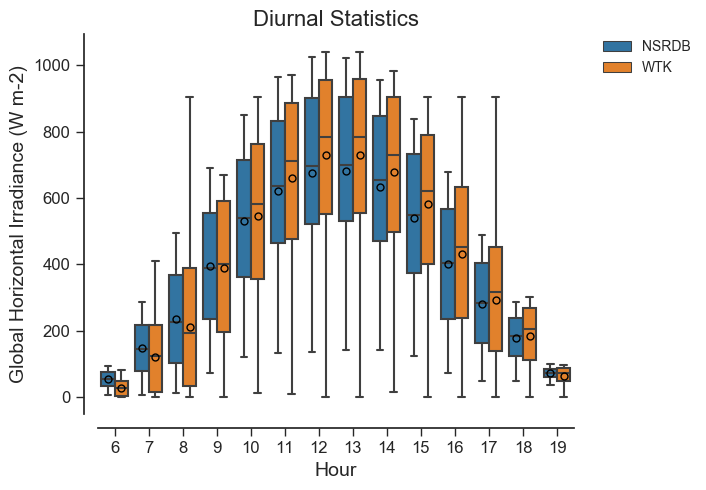

,6,7,8,9,10,11,12,13,14,15,16,17,18,19
p-value,0.0,0.0,0.0,0.0,0.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
variable = 'GHI'
label = 'Global Horizontal Irradiance (W m-2)'

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('year')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('month')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=solar_comp,
           showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('hour')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))

Take aways:
- The average GHI is slightly higher in the WTK on an annual and monthly basis.
- The variability of GHI is slightly greater in the WTK on an annuaul, monthly, and diurnal basis.
- The diurnal pattern of GHI is consistent between the NSRDB and WTK.

#### Diffuse Horizontal Irradiance

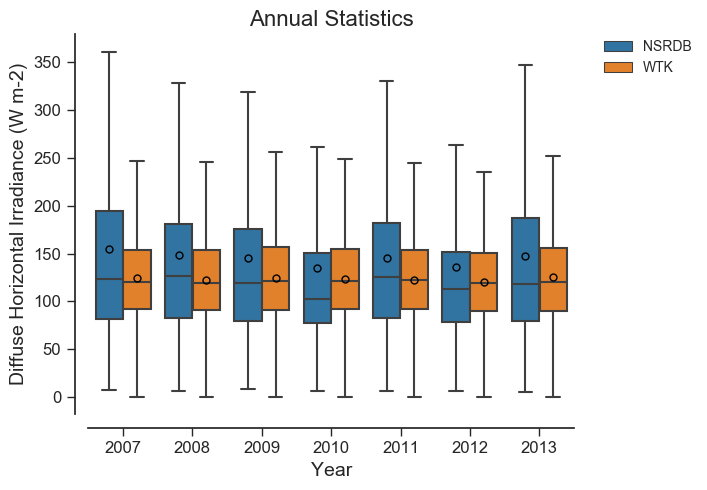

,2007,2008,2009,2010,2011,2012,2013
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0


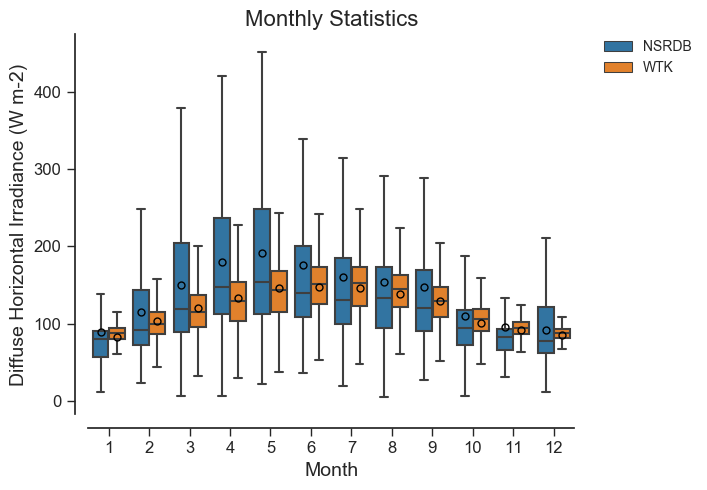

,1,2,3,4,5,6,7,8,9,10,11,12
p-value,0.0,0.11,0.0,0.0,0.0,0.01,0.0,0.0,1.0,0.0,0.0,0.44


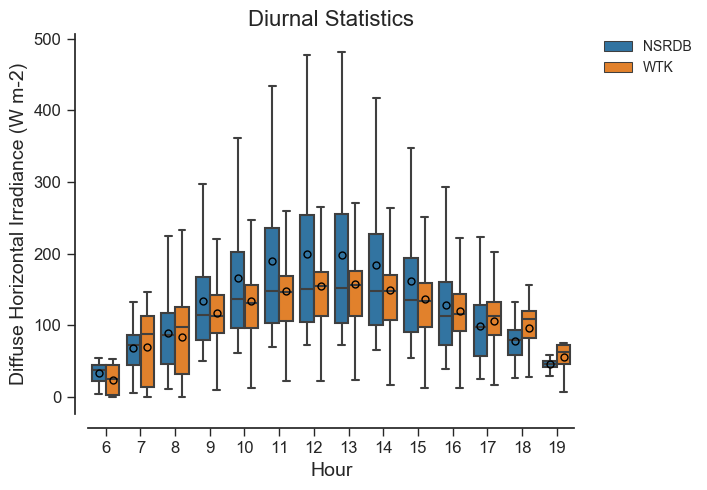

,6,7,8,9,10,11,12,13,14,15,16,17,18,19
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
variable = 'DHI'
label = 'Diffuse Horizontal Irradiance (W m-2)'

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('year')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('month')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=solar_comp,
           showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('hour')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))

Take aways:
- The average DHI is slightly higher in the NSRDB on an annual, monthly, and dirunal basis.
- The variability of DHI is slightly greater in the NSRDB on an annual, monthly, and diurnal basis.
- The monthly pattern of DHI is not well correlated between the NSRDB and WTK.

#### Direct Normal Irradiance

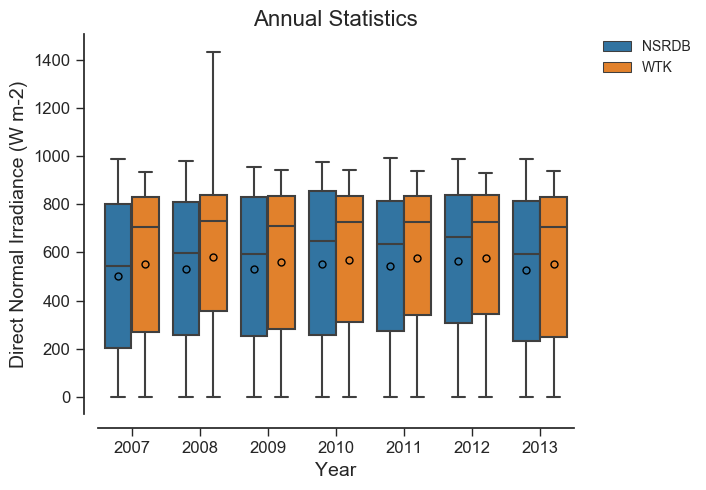

,2007,2008,2009,2010,2011,2012,2013
p-value,0.07,0.0,0.0,0.0,0.32,0.0,0.0


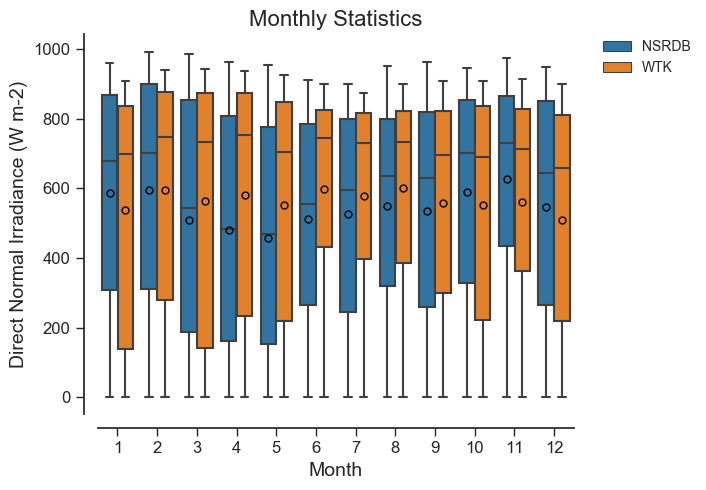

,1,2,3,4,5,6,7,8,9,10,11,12
p-value,0.0,0.0,0.91,0.0,0.0,0.0,0.34,0.04,0.0,0.0,0.0,0.0


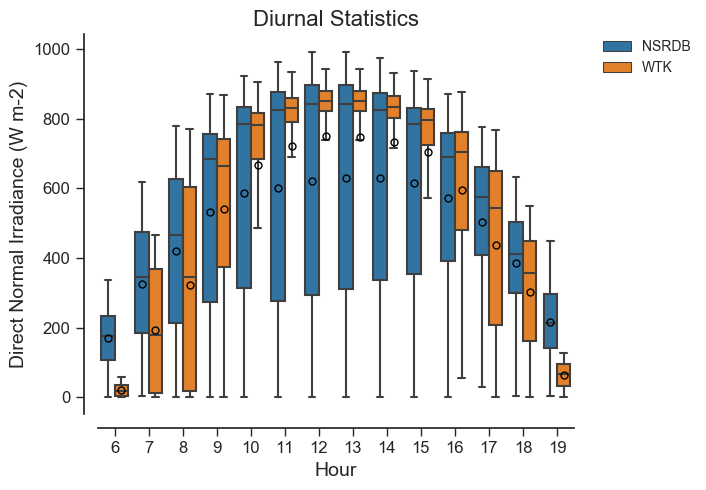

,6,7,8,9,10,11,12,13,14,15,16,17,18,19
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46,0.0,0.0,0.0


In [14]:
variable = 'DNI'
label = 'Direct Normal Irradiance (W m-2)'

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('year')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('month')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=solar_comp,
           showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('hour')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))

Take aways:
- The average DNI is slightly higher in the WTK on an annual basis.
- The median DNI is substantially higher in the WTK on an annual and monthly basis.
- The variability of DNI is comparable between the NSRDB and WTK on an annuaul and monthly basis. 
- The montly pattern of DNI does not match up well between NSRDB and WTK.
- Of significant note is the fact that DNI varies little in the WTK during the middle of the day,
  when the variability is greatest in the NSRDB.

### Conclusions for Irradiance Variables

The discrepencies in irradiance values between NSRDB and WTK can be attributed to poor modeling of  
clouds in the underlying WRF model used to derive the WTK.
- WRF appears to underpredict the total cloud over.
    - A known issue with WRF is the ability to represent thin clouds.
- This is consistent with the higher DNI, GHI, but lower DNI values
- And explains the lack of mid-day variability in DNI

# Meterological Variables

[Temperature](#Surface-Temperature) | [Wind Speed](#Surface-Wind-Speed)

#### Surface Temperature

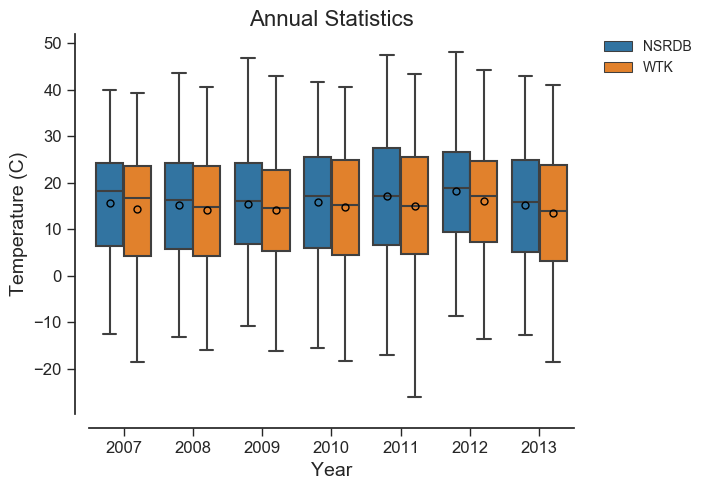

,2007,2008,2009,2010,2011,2012,2013
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0


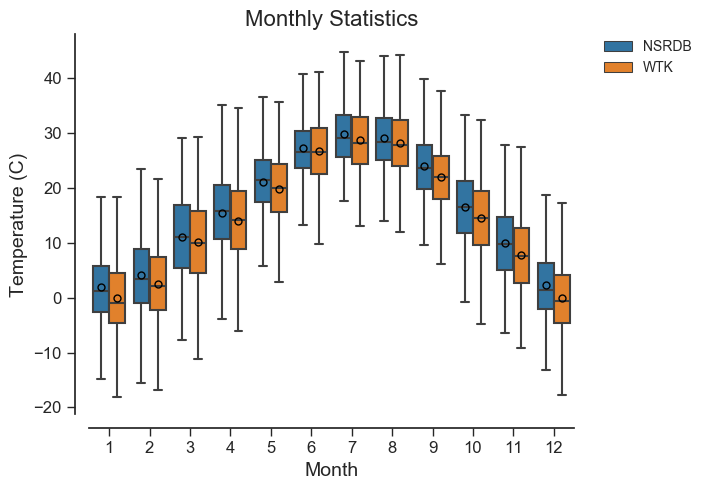

,1,2,3,4,5,6,7,8,9,10,11,12
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


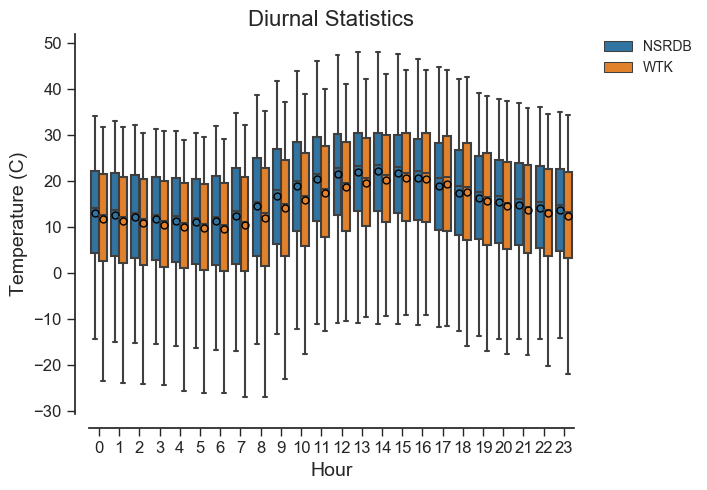

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0


In [15]:
variable = 'Temperature'
label = 'Temperature (C)'

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('year')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('month')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=comp_ds,
           showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('hour')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
with pd.option_context('display.max_rows', None, 'display.max_columns', 24):
    display(p_vals.round(2))

Take aways:
- The average Temperature is slightly higher in the NSRDB across all time scales.
- The variability of Temperature is comparable between the NSRDB and the WTK,  
  though the distribution of tempertures in the WTK is slightly offest from the NSRDB.
- The diurnal pattern appears slightly shifted temporally.

#### Surface Wind Speed

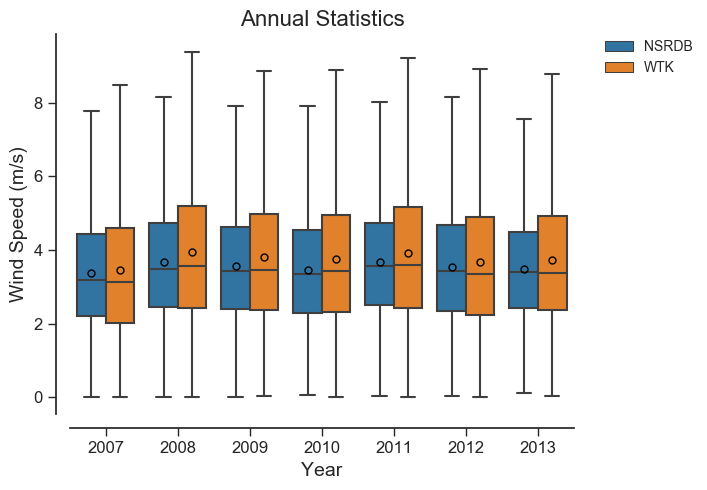

,2007,2008,2009,2010,2011,2012,2013
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0


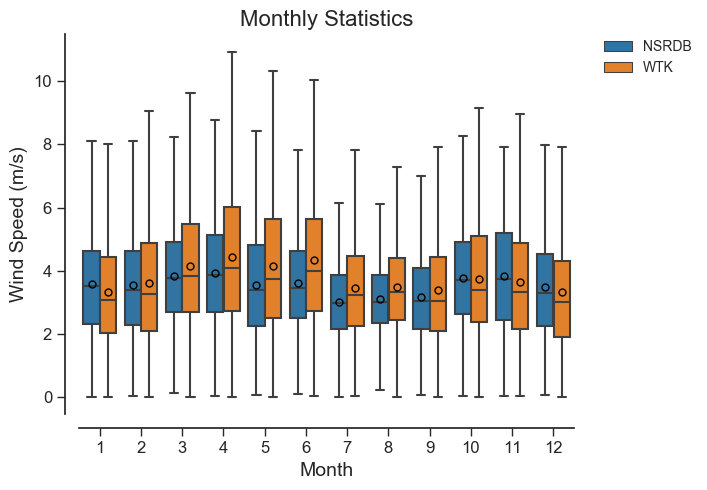

,1,2,3,4,5,6,7,8,9,10,11,12
p-value,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.24,0.0,0.0


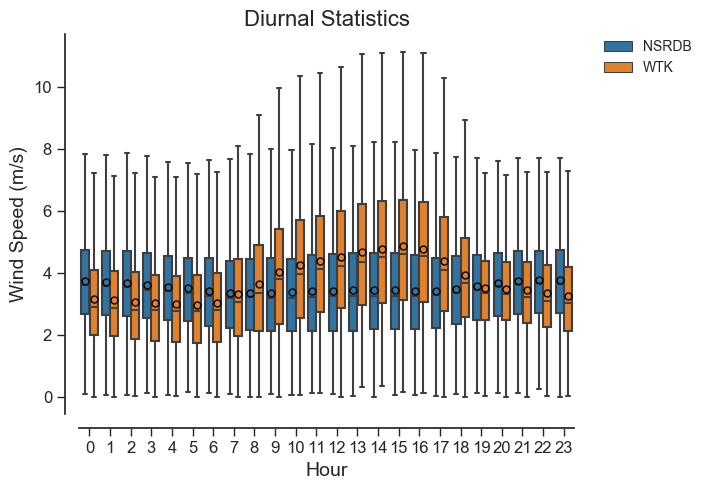

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
variable = 'Wind Speed'
label = 'Wind Speed (m/s)'

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('year')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('month')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=comp_ds,
           showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('hour')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
with pd.option_context('display.max_rows', None, 'display.max_columns', 24):
    display(p_vals.round(2))

Take aways:
- The average Wind Speed is slightly higher in the WTK on an annual basis.
- The variability of Wind Speed is slightly greater in the WTK on an annual and monthly basis.
- There appears to be temporal shift between the monthly patterns in the WTK and NSRDB.
- The diurnal patters are poorly correlated between WTK and NSRDB.

### Conclusions for Meteorological Variables

The NSRDB's Temperature and Wind Speed is pulled from spatially coarse re-analysis data (MERRA).  
The WRF model used to derive the WTK is also derived from coarse re-analysis data (ERA-interim),  
but is then resolved to a much high spatial resolution.

As temperature is not expected to vary significantly spatially it is expected that the NSRDB and WTK temperatures  
should match up closely, which is indeed the case.  
- The slight differences are likley due to differences in the underlying re-analysis data.

Conversely wind speed does vary substantially over small spatial length scales and therefore it is unsurpising  
that the NSRDB and WTK measurements for a given site differ.
- Smoothing over the coarser grid would account for the lower average annual and monthly values in the NSRDB.
- Differences in the monthly and dirunal patterns is likely due to spatial discrepencies in the source data,  
  i.e. the WTK pixel is not coincident with the MERRA pixel used by the NSRDB.

# Statistical Significance
Two sided p-values

In [17]:
annual_stats = pd.DataFrame()
groups = solar_comp.groupby('year')
for group, df in groups:
    for var in ['GHI', 'DHI', 'DNI']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        annual_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]

annual_means = solar_comp.groupby(['dataset', 'year']).mean()
for var in ['GHI', 'DHI', 'DNI']:
    nsrdb = annual_means.loc['NSRDB'][var].values
    wtk = annual_means.loc['WTK'][var].values
    annual_stats.loc['Annual Means', var] = ttest_rel(nsrdb, wtk)[1]


groups = comp_ds.groupby('year')
for group, df in groups:
    for var in ['Temperature', 'Wind Speed']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        annual_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]
        
annual_means = comp_ds.groupby(['dataset', 'year']).mean()
for var in ['Temperature', 'Wind Speed']:
    nsrdb = annual_means.loc['NSRDB'][var].values
    wtk = annual_means.loc['WTK'][var].values
    annual_stats.loc['Annual Means', var] = ttest_rel(nsrdb, wtk)[1]
    
annual_stats.index.name = 'year'
annual_stats.round(2)

,GHI,DHI,DNI,Temperature,Wind Speed
year,,,,,
2007,0.0,0.0,0.07,0.0,0.0
2008,0.0,0.0,0.00,0.0,0.0
2009,0.0,0.0,0.00,0.0,0.0
2010,0.0,0.0,0.00,0.0,0.0
2011,0.0,0.0,0.32,0.0,0.0
2012,0.0,0.0,0.00,0.0,0.0
2013,0.0,0.0,0.00,0.0,0.0
Annual Means,0.0,0.0,0.00,0.0,0.0


In [18]:
monthly_stats = pd.DataFrame()
groups = solar_comp.groupby('month')
for group, df in groups:
    for var in ['GHI', 'DHI', 'DNI']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        monthly_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]

monthly_means = solar_comp.groupby(['dataset', 'month']).mean()
for var in ['GHI', 'DHI', 'DNI']:
    nsrdb = monthly_means.loc['NSRDB'][var].values
    wtk = monthly_means.loc['WTK'][var].values
    monthly_stats.loc['Monthly Means', var] = ttest_rel(nsrdb, wtk)[1]


groups = comp_ds.groupby('month')
for group, df in groups:
    for var in ['Temperature', 'Wind Speed']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        monthly_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]
        
monthly_means = comp_ds.groupby(['dataset', 'month']).mean()
for var in ['Temperature', 'Wind Speed']:
    nsrdb = monthly_means.loc['NSRDB'][var].values
    wtk = monthly_means.loc['WTK'][var].values
    monthly_stats.loc['Monthly Means', var] = ttest_rel(nsrdb, wtk)[1]
    
monthly_stats.index.name = 'month'
monthly_stats.round(2)

,GHI,DHI,DNI,Temperature,Wind Speed
month,,,,,
1,0.00,0.00,0.00,0.0,0.00
2,0.00,0.11,0.00,0.0,0.01
3,0.57,0.00,0.91,0.0,0.00
4,0.00,0.00,0.00,0.0,0.00
5,0.00,0.00,0.00,0.0,0.00
6,0.00,0.01,0.00,0.0,0.00
7,0.00,0.00,0.34,0.0,0.00
8,0.00,0.00,0.04,0.0,0.00
9,0.18,1.00,0.00,0.0,0.00


In [19]:
diurnal_stats = pd.DataFrame()
groups = solar_comp.groupby('hour')
for group, df in groups:
    for var in ['GHI', 'DHI', 'DNI']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        diurnal_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]

groups = comp_ds.groupby('hour')
for group, df in groups:
    for var in ['Temperature', 'Wind Speed']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        diurnal_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]
        
diurnal_stats = diurnal_stats.sort_index()
        
diurnal_means = solar_comp.groupby(['dataset', 'hour']).mean()
for var in ['GHI', 'DHI', 'DNI']:
    nsrdb = diurnal_means.loc['NSRDB'][var].values
    wtk = diurnal_means.loc['WTK'][var].values
    diurnal_stats.loc['Diurnal Means', var] = ttest_rel(nsrdb, wtk)[1]
        
diurnal_means = comp_ds.groupby(['dataset', 'hour']).mean()
for var in ['Temperature', 'Wind Speed']:
    nsrdb = diurnal_means.loc['NSRDB'][var].values
    wtk = diurnal_means.loc['WTK'][var].values
    diurnal_stats.loc['Diurnal Means', var] = ttest_rel(nsrdb, wtk)[1]
    
diurnal_stats.index.name = 'hour'
diurnal_stats.round(2)

,GHI,DHI,DNI,Temperature,Wind Speed
hour,,,,,
0,NaN,NaN,NaN,0.00,0.00
1,NaN,NaN,NaN,0.00,0.00
2,NaN,NaN,NaN,0.00,0.00
3,NaN,NaN,NaN,0.00,0.00
4,NaN,NaN,NaN,0.00,0.00
5,NaN,NaN,NaN,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.02
8,0.00,0.00,0.00,0.00,0.00
